<h1><center>Simple YoloX Dataset Generator (COCO-JSON)</center></h1>     

<center><img src = "https://i.imgur.com/iatgdo5.jpg" width = "635" height = "235"/></center>         

This dataset was built to be compatible with the train (train.py) script that can be found [HERE](https://github.com/Megvii-BaseDetection/YOLOX). I also have a training notebook that you can find [HERE](https://www.kaggle.com/coldfir3/yolox). The inference notebook is still WIP. The resulting kaggle Dataset cand be found [HERE](https://www.kaggle.com/coldfir3/cots-yolox-dataset)

The tree main tasks into converting this dataset to YoloX format are:
1. Splitting into train and test
1. Converting the bboxes to COCO format
1. Saving the annotations to a .json file

I took inspiration on [this](https://www.kaggle.com/remekkinas/yolox-training-pipeline-cots-dataset-lb-0-507) amazing notebook

<h3 style='background:orange; color:black'><center>Consider upvoting this notebook if you found it helpful.</center></h3>

## Loading the DataFrame and spliting into train/test

I have a whole discussion topic ([here](https://www.kaggle.com/c/tensorflow-great-barrier-reef/discussion/293723)) where I explain why I think spliting by video is the best approach, but feel free to change the train/val split strategy

In [1]:
import numpy as np
from ast import literal_eval
import pandas as pd
from tqdm.notebook import tqdm

FOLD = 0
empty_img_percent = 0

TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef/train_images'
N_SAMP = 6000

train = pd.read_csv('/kaggle/input/tensorflow-great-barrier-reef/train.csv')

train['annotations'] = train['annotations'].apply(literal_eval)
train['num_bbox'] = train['annotations'].apply(lambda x: len(x))
train['is_valid'] = train['video_id'].apply(lambda x: 1 if x == FOLD else 0)
train['path'] = train.apply(lambda row: f"{TRAIN_PATH}/video_{row['video_id']}/{row['video_frame']}.jpg", axis = 1)

For each sequence add 20% of empty images

In [2]:
# # For each sequence get only rows with annotations but also add X% of rows without annotations
# sequences = train.sequence.unique()
# indexes_to_save = list()

# # For each sequence get indexes of rows without annotations to save in dataset
# for i in range(len(sequences)):
#     sequence_len = len(train[(train.sequence == sequences[i])])
#     empty_indexes = list(train[(train.sequence == sequences[i]) & (train.num_bbox == 0)].index)
#     non_empty_indexes_len = sequence_len - len(empty_indexes)
#     if len(empty_indexes) == 0 or non_empty_indexes_len == 0:
#         continue
#     np.random.seed(42)
#     indexes_to_save.extend(np.random.choice(empty_indexes, int(non_empty_indexes_len*(empty_img_percent)/100)+1, replace=False))

# train = train[(train.index.isin(indexes_to_save)) | (train.num_bbox > 0)]
train = train[(train.num_bbox > 0) | (train.video_id == FOLD)]

train.to_csv('train.csv')

## Converting to COCO

In [3]:
def to_coco(df):
    annotion_id = 0
    images = []
    annotations = []

    categories = [{'id': 0, 'name': 'cots'}]

    for i, row in tqdm(df.iterrows(), total = len(df)):

        images.append({
            "id": i,
            "file_name": f"{row['image_id']}.jpg",
            "height": 720,
            "width": 1280,
        })
        for bbox in row['annotations']:
            annotations.append({
                "id": annotion_id,
                "image_id": i,
                "category_id": 0,
                "bbox": list(bbox.values()),
                "area": bbox['width'] * bbox['height'],
                "segmentation": [],
                "iscrowd": 0
            })
            annotion_id += 1

    json_file = {'categories':categories, 'images':images, 'annotations':annotations}
    return json_file

In [4]:
json_train = to_coco(train[train['is_valid'] == 0])
json_valid = to_coco(train[train['is_valid'] == 1])

  0%|          | 0/2776 [00:00<?, ?it/s]

  0%|          | 0/6708 [00:00<?, ?it/s]

## Saving into a json file

In [5]:
import json

with open('/kaggle/working/annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(json_train, f, ensure_ascii=True, indent=4)
    
with open('/kaggle/working/annotations_valid.json', 'w', encoding='utf-8') as f:
    json.dump(json_valid, f, ensure_ascii=True, indent=4)

In [6]:
import os
os.makedirs('/kaggle/working/train2017', exist_ok=True)
os.makedirs('/kaggle/working/val2017', exist_ok=True)

In [7]:
import shutil
for i, row in tqdm(train.iterrows(), total = len(train)):
    base_dir = 'val2017' if row['is_valid'] == 1 else 'train2017'
    fname = f"{row['image_id']}.jpg"
    shutil.copyfile(row['path'], f"/kaggle/working/{base_dir}/{fname}")

  0%|          | 0/9484 [00:00<?, ?it/s]

## Sanity check

In [8]:
!pip install -Uqqq 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [9]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
from random import sample

In [10]:
data_dir = '/kaggle/working/train2017'
ann_file = '/kaggle/working/annotations_train.json'
coco = COCO(ann_file)
img_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


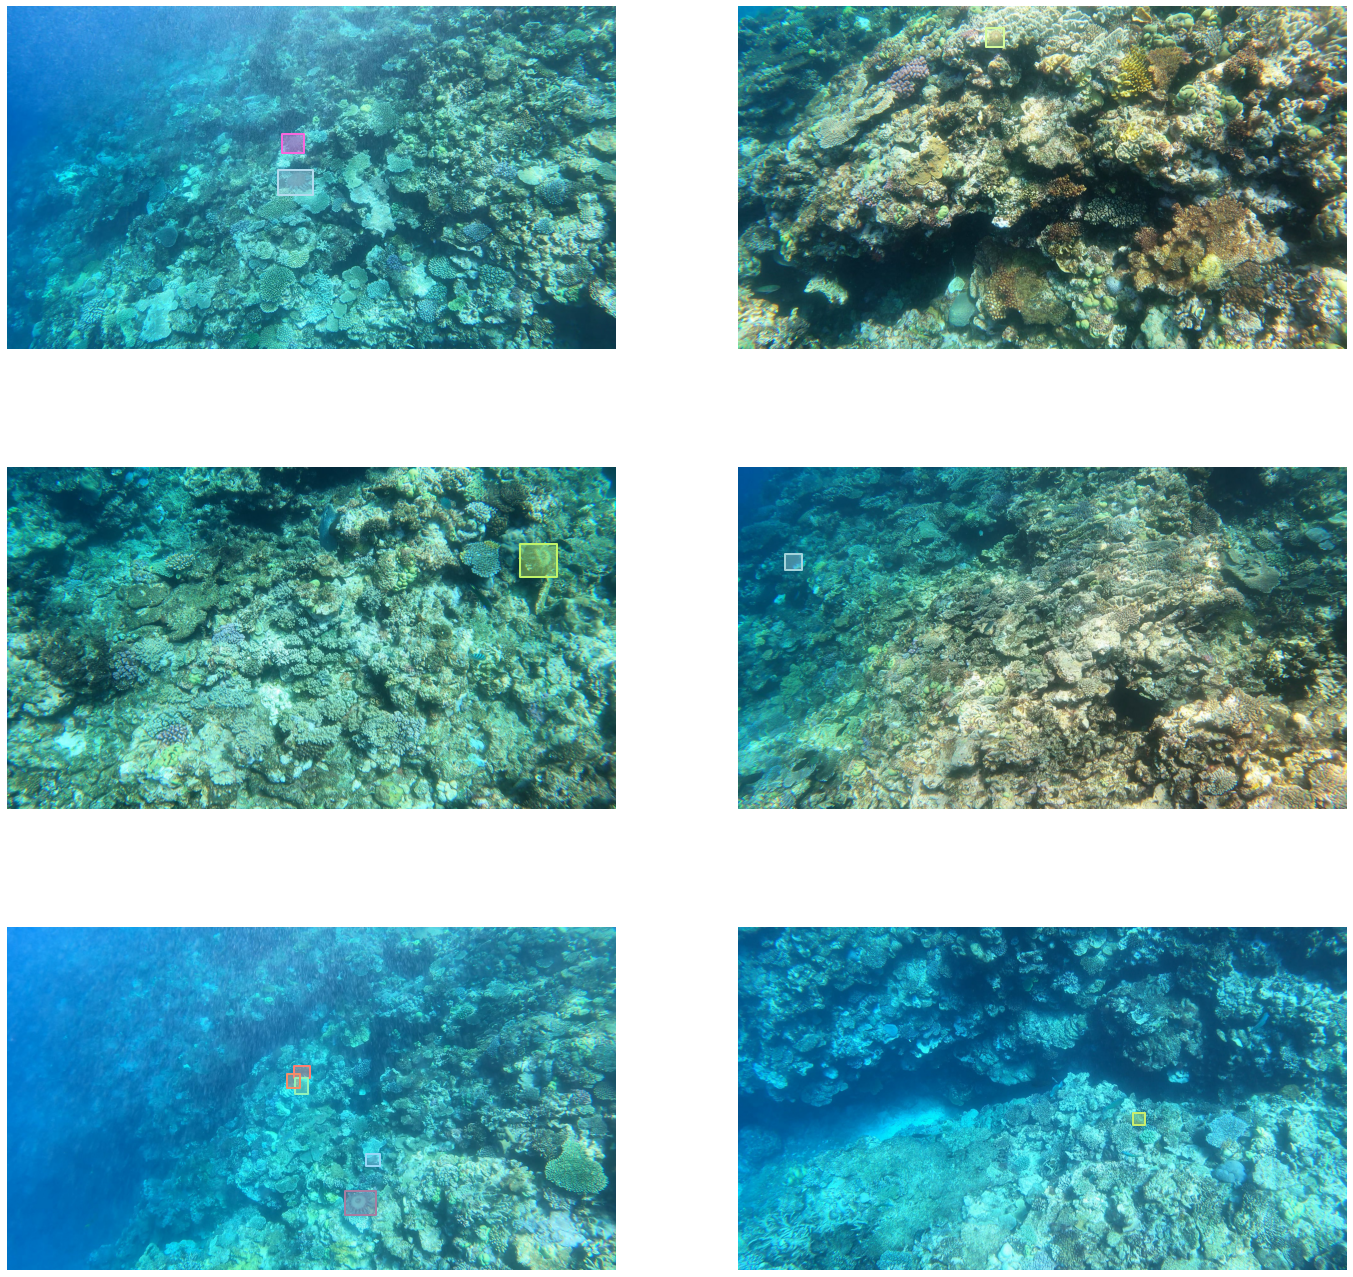

In [11]:
n_row = 3
n_col = 2
imgs = coco.loadImgs(sample(img_ids, n_row * n_col))
_, axs = plt.subplots(n_row, n_col, figsize=(12 * n_col, 8 * n_row))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    
    img_img = Image.open(f"{data_dir}/{img['file_name']}")
    anns = coco.loadAnns(coco.getAnnIds(imgIds=[img['id']]))
    ax.imshow(img_img)
    plt.sca(ax)
    coco.showAnns(anns, draw_bbox=True)
    plt.axis('off')
plt.show()

## Ziping the files so kaggle can assemble a dataset

the final dataset can be found [HERE](https://www.kaggle.com/coldfir3/great-barrier-reef-yolov5)

In [12]:
shutil.make_archive('val2017', 'zip', 'val2017')
shutil.make_archive('train2017', 'zip', 'train2017')

'/kaggle/working/train2017.zip'

In [13]:
shutil.rmtree('val2017') 
shutil.rmtree('train2017') 